# Math symbol classifier

Train a Neural network model using PyTorch to classify images of math symbols to actual math symbol.

Tasks:
- Read input_data.csv into DataFrame
- LabelEncode the classes
- Split the data into train and test datasets
- Prepare the Datasets and DataLoaders for train and test
- Build a custom NN model for training
- Train and evaluate the model
- Save the model into a file

In [1]:
# !conda install scikit-learn -n pyimgsearch-env -y

## Import required libraries

In [2]:
import numpy as np
import pandas as pd

import torch
from torch import nn, functional, optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy
from tqdm.notebook import tqdm

## Load the data into the DataFrame

In [3]:
data = pd.read_csv('data/input_data.csv')
data.head()

/opt/homebrew/Caskroom/miniforge/base/envs/pyimgsearch-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (784) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,73,255,255,255,255,218,0,0,0,0,...,0,0,0,0,0,0,0,0,0,div
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,div
2,255,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,div
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,div
4,0,0,0,0,0,0,0,141,255,255,...,0,0,0,0,0,0,0,0,0,div


## LabelEncode the target classes

In [4]:
data['784'] = data['784'].astype(str)
encoder = LabelEncoder()
data['784'] = encoder.fit_transform(data['784'])

data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,73,255,255,255,255,218,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
2,255,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
4,0,0,0,0,0,0,0,141,255,255,...,0,0,0,0,0,0,0,0,0,13


In [5]:
encoder.classes_

array(['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=',
       'div', 'times'], dtype=object)

In [6]:
data.columns[:-1]

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '774', '775', '776', '777', '778', '779', '780', '781', '782', '783'],
      dtype='object', length=784)

In [7]:
X = data.iloc[:, :-1].values/255 #Normalize the data
y = data['784'].values

In [8]:
print(X.shape, y.shape)

(52496, 784) (52496,)


In [9]:
100*pd.DataFrame(y, index=None).value_counts(normalize=True)

0     7.619628
1     7.619628
2     7.619628
3     7.619628
4     7.619628
5     7.619628
6     7.619628
12    7.619628
11    7.118638
7     6.752895
14    6.192853
8     5.939500
10    5.844255
9     5.541375
13    1.653459
dtype: float64

## Split the dataset into train and test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 41)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(41996, 784) (41996,)
(10500, 784) (10500,)


In [11]:
100*pd.DataFrame(y_train, index=None).value_counts(normalize=True)

1     7.707877
12    7.622154
4     7.612630
2     7.610249
0     7.607867
3     7.600724
6     7.586437
5     7.562625
11    7.138775
7     6.710163
14    6.231546
8     5.952948
10    5.898181
9     5.524336
13    1.633489
dtype: float64

In [12]:
100*pd.DataFrame(y_test, index=None).value_counts(normalize=True)

5     7.847619
6     7.752381
3     7.695238
0     7.666667
2     7.657143
4     7.647619
12    7.609524
1     7.266667
11    7.038095
7     6.923810
14    6.038095
8     5.885714
10    5.628571
9     5.609524
13    1.733333
dtype: float64

## Prepare the Datasets and Dataloaders for train and test

In [13]:
batch_size=32

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(y_train).type(torch.LongTensor) 
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train,y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)


In [14]:
dataloaders = {
    'train':train_loader,
    'val':test_loader
}

In [15]:
dataset_sizes = {
    'train': len(train), 
    'val': len(test)
}

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Build a custom NN model

In [17]:
class NN_Classifier(nn.Module):
    def __init__(self, classes_len):
        super(NN_Classifier,self).__init__()
        self.cnn_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride=1, padding=0)
        self.cnn_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.2)
        self.dropout2d = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64) 
        self.out = nn.Linear(64, classes_len) 
        
    def forward(self,x):
        
        out = self.cnn_1(x)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = self.cnn_2(out)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.out(out)
        
        return out

## Train and evaluate the model

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in tqdm(['train', 'val']):
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = Variable(inputs.view(-1,1,28,28))
                labels = Variable(labels)
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs.shape)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders['val'])):
            inputs = Variable(inputs.view(-1,1,28,28))
            labels = Variable(labels)
                
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in tqdm(range(inputs.size()[0])):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(encoder.classes_[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
# Get GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
model = NN_Classifier(classes_len=len(encoder.classes_))
model = model.double()
model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 2.3077 Acc: 0.2435


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 1.6018 Acc: 0.5004

Epoch 1/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 1.3652 Acc: 0.5923


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.9528 Acc: 0.7198

Epoch 2/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.9252 Acc: 0.7170


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.6787 Acc: 0.7907

Epoch 3/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.7443 Acc: 0.7690


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.5493 Acc: 0.8370

Epoch 4/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.6526 Acc: 0.7940


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.4888 Acc: 0.8502

Epoch 5/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.5900 Acc: 0.8097


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.4396 Acc: 0.8650

Epoch 6/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.5416 Acc: 0.8236


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3980 Acc: 0.8745

Epoch 7/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.5004 Acc: 0.8363


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3840 Acc: 0.8798

Epoch 8/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4959 Acc: 0.8387


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3812 Acc: 0.8787

Epoch 9/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4938 Acc: 0.8376


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3790 Acc: 0.8798

Epoch 10/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4805 Acc: 0.8411


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3748 Acc: 0.8805

Epoch 11/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4831 Acc: 0.8411


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3726 Acc: 0.8825

Epoch 12/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4821 Acc: 0.8431


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3688 Acc: 0.8825

Epoch 13/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4737 Acc: 0.8437


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3670 Acc: 0.8811

Epoch 14/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4716 Acc: 0.8452


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3656 Acc: 0.8817

Epoch 15/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4720 Acc: 0.8441


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3655 Acc: 0.8825

Epoch 16/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4719 Acc: 0.8442


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3651 Acc: 0.8822

Epoch 17/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4712 Acc: 0.8442


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3650 Acc: 0.8819

Epoch 18/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4675 Acc: 0.8442


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3648 Acc: 0.8827

Epoch 19/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4652 Acc: 0.8466


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3644 Acc: 0.8814

Epoch 20/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4651 Acc: 0.8474


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3643 Acc: 0.8822

Epoch 21/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4708 Acc: 0.8447


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3642 Acc: 0.8823

Epoch 22/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4725 Acc: 0.8437


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3642 Acc: 0.8825

Epoch 23/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4693 Acc: 0.8469


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3641 Acc: 0.8826

Epoch 24/24
----------


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

train Loss: 0.4699 Acc: 0.8462


  0%|          | 0/329 [00:00<?, ?it/s]

val Loss: 0.3641 Acc: 0.8821

Training complete in 7m 2s
Best val Acc: 0.882667


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

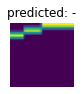

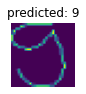

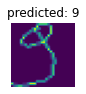

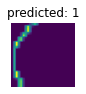

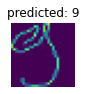

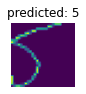

In [23]:
visualize_model(model_ft)

## Save the model to a file

In [24]:
torch.save(model_ft, 'data/model_acc_88.pth')